In [1]:
import sys
sys.path.append('..')

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.timescale_connector import TimescaleConnector


In [2]:
data = TimescaleConnector.query_ohlcv_daily("ACB")

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

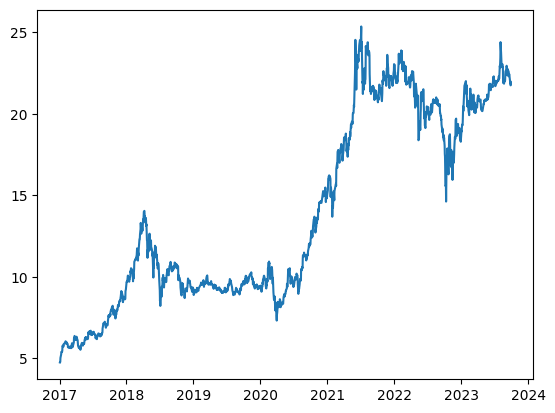

In [4]:
# EDA
data["date"] = pd.to_datetime(data["date"])

plt.plot(data["date"], data["close"])

In [5]:
from copy import deepcopy as dc

data = data[["date", "close"]]

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index("date", inplace=True)

    for i in range(1, n_steps + 1):
        df[f"close(t-{i})"] = df["close"].shift(i)

    df.dropna(inplace=True)

    return df


lookback = 5
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,close,close(t-1),close(t-2),close(t-3),close(t-4),close(t-5)
date,,,,,,
2017-01-10,5.25,5.20,5.03,4.78,4.78,4.75
2017-01-11,5.40,5.25,5.20,5.03,4.78,4.78
2017-01-12,5.40,5.40,5.25,5.20,5.03,4.78
2017-01-13,5.38,5.40,5.40,5.25,5.20,5.03
2017-01-16,5.45,5.38,5.40,5.40,5.25,5.20
...,...,...,...,...,...,...
2023-09-25,22.00,22.30,22.40,22.45,22.30,22.45
2023-09-26,21.90,22.00,22.30,22.40,22.45,22.30
2023-09-27,22.00,21.90,22.00,22.30,22.40,22.45


In [6]:
# Transform to numpy arrays
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 5.25,  5.2 ,  5.03,  4.78,  4.78,  4.75],
       [ 5.4 ,  5.25,  5.2 ,  5.03,  4.78,  4.78],
       [ 5.4 ,  5.4 ,  5.25,  5.2 ,  5.03,  4.78],
       ...,
       [22.  , 21.9 , 22.  , 22.3 , 22.4 , 22.45],
       [21.75, 22.  , 21.9 , 22.  , 22.3 , 22.4 ],
       [21.85, 21.75, 22.  , 21.9 , 22.  , 22.3 ]])

In [7]:
# scale the data to range from -1 to 1, matched the range of the tanh activation function
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        ],
       [-0.98508205, -0.99503968, -0.98327595, -0.97570457, -1.        ,
        -0.99708879],
       [-0.98508205, -0.98015873, -0.97835711, -0.95918367, -0.97570457,
        -0.99708879],
       ...,
       [ 0.66583789,  0.65674603,  0.66945401,  0.70262391,  0.71234208,
         0.71761281],
       [ 0.64097464,  0.66666667,  0.65961633,  0.67346939,  0.70262391,
         0.7127608 ],
       [ 0.65091994,  0.64186508,  0.66945401,  0.66375121,  0.67346939,
         0.70305677]])

In [8]:
X = shifted_df_as_np[:, 1:] # input features
y = shifted_df_as_np[:, 0] # target feature

X.shape, y.shape

((1675, 5), (1675,))

In [9]:
split_index = int(len(X) * 0.95)
split_index

1591

In [10]:
# Train test split
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1591, 5), (84, 5), (1591,), (84,))

In [11]:
# Reshaping the data to add an extra dimension for PyTorch lstm
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1591, 5, 1), (84, 5, 1), (1591, 1), (84, 1))

In [12]:
# Transform numpy arrays to tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [13]:
# Create a dataset for torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [14]:
# Create a DataLoader
from torch.utils.data import DataLoader

batch_size = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
# Check the shape of the of the input and target tensors
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([10, 5, 1]) torch.Size([10, 1])


In [16]:
# Create a LSTM class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 6, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 6, batch_first=True)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)

In [17]:
# Train function
def train_one_epoch():
    model.train(True)
    print(f"Epoch: {epoch + 1}")
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print(
                "Batch {0}, Loss: {1:.3f}".format(
                    batch_index + 1, avg_loss_across_batches
                )
            )
            running_loss = 0.0
    print()

In [18]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print("Val Loss: {0:.3f}".format(avg_loss_across_batches))
    print("***************************************************")

In [19]:
learning_rate = 0.01
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.053

Val Loss: 0.102
***************************************************
Epoch: 2
Batch 100, Loss: 0.128

Val Loss: 0.076
***************************************************
Epoch: 3
Batch 100, Loss: 0.041

Val Loss: 0.023
***************************************************
Epoch: 4
Batch 100, Loss: 0.021

Val Loss: 0.005
***************************************************
Epoch: 5
Batch 100, Loss: 0.019

Val Loss: 0.006
***************************************************
Epoch: 6
Batch 100, Loss: 0.016

Val Loss: 0.004
***************************************************
Epoch: 7
Batch 100, Loss: 0.012

Val Loss: 0.003
***************************************************
Epoch: 8
Batch 100, Loss: 0.012

Val Loss: 0.003
***************************************************
Epoch: 9
Batch 100, Loss: 0.011

Val Loss: 0.002
***************************************************
Epoch: 10
Batch 100, Loss: 0.011

Val Loss: 0.002
*****************************************

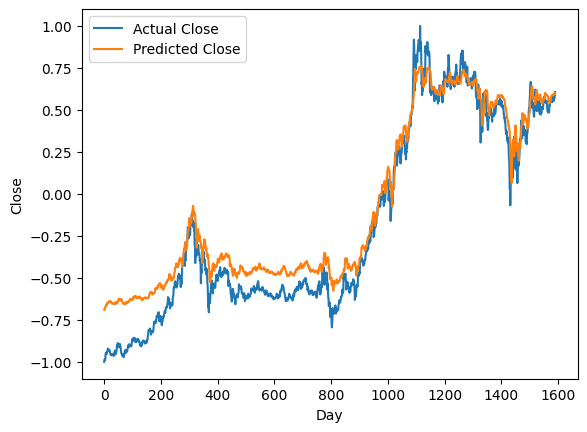

In [20]:
# Plot the results
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [21]:
# Scale back the data

train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 8.38498721,  8.402575  ,  8.39303614, ..., 21.37269994,
       21.30735317, 21.29395347])

In [22]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 5.25      ,  5.40000019,  5.40000019, ..., 21.05000015,
       21.2199998 , 21.39999978])

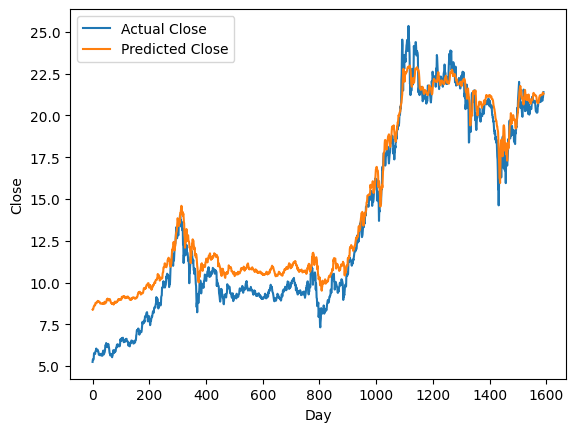

In [23]:
# Proper scale
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


**Prediction**

In [24]:
# Predict and scale back the test data

test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([21.30151455, 21.38213451, 21.45847769, 21.57933391, 21.70140916,
       21.81166933, 21.79926091, 21.79629066, 21.76297539, 21.68143607,
       21.66574215, 21.66937885, 21.728356  , 21.75368346, 21.77220499,
       21.77702596, 21.74036167, 21.75922961, 21.79972359, 21.85530136,
       21.97327963, 22.05018258, 22.02601661, 22.001527  , 21.91912585,
       21.94912685, 21.92720954, 21.88862502, 21.84574813, 21.79768349,
       21.83880675, 21.90859212, 21.91069695, 21.89426107, 21.93445777,
       21.93445777, 21.93584461, 21.93903542, 21.94877804, 21.96980115,
       22.00634198, 22.02666148, 22.08861488, 22.0960453 , 22.12439336,
       22.24956712, 22.43988388, 22.49705945, 22.62296439, 22.7320331 ,
       22.77215069, 22.62141214, 22.52171088, 22.45088269, 22.39686675,
       22.40118189, 22.39112402, 22.31471132, 22.24137076, 22.08994418,
       21.90671264, 21.93092895, 21.92674806, 21.90059713, 21.95188733,
       21.95834206, 22.0244296 , 22.10464441, 22.24076903, 22.30

In [25]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([21.79999988, 21.75000001, 21.79999988, 21.84999974, 21.59999983,
       21.54999997, 21.45000024, 21.59999983, 21.65000029, 21.70000015,
       21.79999988, 21.65000029, 21.65000029, 21.70000015, 21.65000029,
       21.9000002 , 22.24999983, 22.19999997, 22.30000029, 21.9000002 ,
       22.04999979, 22.04999979, 21.99999992, 21.95000006, 21.70000015,
       21.70000015, 21.95000006, 21.99999992, 21.84999974, 21.99999992,
       21.99999992, 21.99999992, 21.99999992, 21.99999992, 21.99999992,
       22.10000025, 22.04999979, 22.30000029, 22.30000029, 22.15000011,
       22.19999997, 22.9500003 , 22.84999997, 23.09999988, 23.45000012,
       24.39999989, 23.74999989, 23.40000025, 23.20000021, 22.89999984,
       22.89999984, 23.05000002, 22.84999997, 22.89999984, 22.69999979,
       21.9000002 , 21.99999992, 22.04999979, 21.84999974, 22.04999979,
       21.95000006, 22.04999979, 22.04999979, 22.44999988, 22.60000007,
       22.75000025, 22.9500003 , 22.89999984, 22.75000025, 22.35

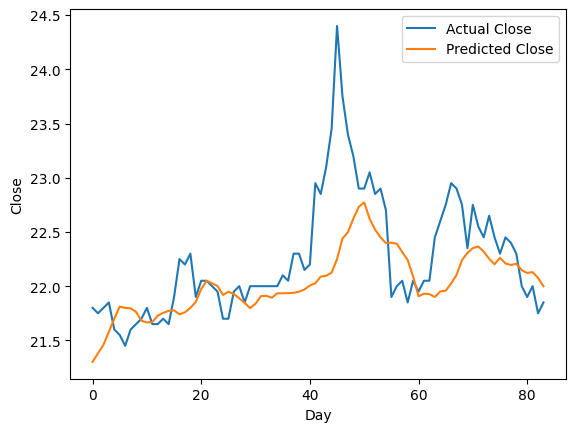

In [26]:
# Plot the predictions results

plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [27]:
# Stats for the train and test data
print("Training data stats:")
print(f"Min: {np.min(new_y_train)}")
print(f"Max: {np.max(new_y_train)}")
print(f"Mean: {np.mean(new_y_train)}")
print(f"Standard Deviation: {np.std(new_y_train)}")

print("\nTest data stats:")
print(f"Min: {np.min(new_y_test)}")
print(f"Max: {np.max(new_y_test)}")
print(f"Mean: {np.mean(new_y_test)}")
print(f"Standard Deviation: {np.std(new_y_test)}")

Training data stats:
Min: 5.249999999999999
Max: 25.36
Mean: 13.553218094176648
Standard Deviation: 5.717523292064308

Test data stats:
Min: 21.45000024229288
Max: 24.399999892413614
Mean: 22.249404774428836
Standard Deviation: 0.5450804941685259


In [28]:
# Calculate the RMSE
from sklearn.metrics import mean_squared_error

train_rmse = np.sqrt(mean_squared_error(new_y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(new_y_test, test_predictions))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 1.3894925333887698
Test RMSE: 0.4758043905736043
